In [1]:
from json import load
from typing import List, Dict
import re
import unicodedata
from sklearn.metrics import precision_score, recall_score, f1_score
from strsimpy.levenshtein import Levenshtein
from pathlib import Path
from glob import glob
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
ground_truth_dir = "../../data/metadata_extraction_data/metadata"
pred_dir = "../../data/metadata_extraction_data/grobid_metadata"

In [3]:
def _strip_controls(text: str) -> str:
    """Drop all Unicode control characters (category C*)."""
    return "".join(c for c in text if unicodedata.category(c)[0] != "C")

def _fix_accents(text: str) -> str:
    """
    Remove diacritics (accents) but keep other characters unchanged.
    """
    return "".join(
        c for c in unicodedata.normalize("NFD", text) if unicodedata.category(c) != "Mn"
    )

def _clean_item(text: str) -> str:
    """
    Lower-case, strip accents, trim whitespace, collapse internal spaces.
    """
    text = _strip_controls(_fix_accents(text.lower()))
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def levenshtein_distance(s0, s1):
    return Levenshtein().distance(s0, s1)

def cosine_sim(a: str, b: str) -> float:
    """
    TF-IDF cosine similarity between two texts.
    """
    if a and b:
        vect = TfidfVectorizer(stop_words="english")
        mat = vect.fit_transform([a, b])
        return round(float(cosine_similarity(mat[0:1], mat[1:2])[0, 0]), 2)
    else: return 1

def f1_on_sets(true_set, pred_set):
    """
    Element-level F1 score treating both inputs as sets after normalisation.
    """
    if not true_set and not pred_set:
        return 1, 1, 1
    if true_set and not pred_set:
        return 0, 0, 0
    if not true_set and pred_set:
        return 0, 0, 0
    if len(true_set) == 1 and len(pred_set) == 1:
        return float(true_set == pred_set), float(true_set == pred_set), float(true_set == pred_set)
    labels = sorted(true_set|pred_set)                 # union of both sets

    # ── 3. Convert each set to a binary indicator row (1 = label present) ─────────
    mlb = MultiLabelBinarizer(classes=labels)
    y_true_bin = mlb.fit_transform([true_set])   # shape (1, n_labels)
    y_pred_bin = mlb.transform([pred_set])  
    
    # ── 4. Micro-averaged metrics for multi-label classification ───────────────────
    prec  = round(precision_score(y_true_bin, y_pred_bin, average='samples'), 2)
    rec   = round(recall_score(y_true_bin, y_pred_bin, average='samples'), 2)
    f1    = round(f1_score(y_true_bin, y_pred_bin, average='samples'), 2)

    return (prec, rec, f1)

In [4]:
def evaluate_record(
    y_true: Dict, y_predicted: Dict
) -> List[Dict[str, object]]:
    rows: List[Dict[str, object]] = []

    for field in ("title", "doi", "publication_date", "publisher"):
        gt = _clean_item(y_true.get(field, ""))
        pd_ = _clean_item(y_predicted.get(field, ""))
        match = levenshtein_distance(gt, pd_)
        rows.append(
            dict(
                field=field,
                metric="levenshtein_distance",
                score=float(match),
                ground_truth=gt,
                predicted=pd_,
            )
        )
    
    for field in ["abstract"]:
        gt = _clean_item(y_true.get(field, ""))
        pd_ = _clean_item(y_predicted.get(field, ""))
        cos_similarity = cosine_sim(gt, pd_)
        rows.append(
            dict(
                field=field,
                metric="cosine_similarity",
                score=cos_similarity,
                ground_truth=gt,
                predicted=pd_,
            )
        )

    for field in ("authors", "affiliations", "keywords"):
        gt_list = y_true.get(field, [])
        pd_list = y_predicted.get(field, [])
        true_set = {_clean_item(x) for x in gt_list}
        pred_set = {_clean_item(x) for x in pd_list}
        _,_,f1 = f1_on_sets(true_set, pred_set)
        rows.append(
            dict(
                field=field,
                metric="F1_set",
                score=f1,
                ground_truth="; ".join(true_set),
                predicted="; ".join(pred_set),
            )
        )

    return rows


In [5]:
files = glob(str(Path(ground_truth_dir)/"*.json"))
all_metrics=[]
for ground_truth_file in files:
    name = Path(ground_truth_file).stem
    pred_file = Path(pred_dir) / f"{name}.grobid.json"
    with open(pred_file, encoding="utf-8") as f:
        y_pred = load(f)

    with open(ground_truth_file, encoding="utf-8") as f:
        y = load(f)
    results = evaluate_record(y, y_pred)
    all_metrics.append(results)

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data\\metadata_extraction_data\\grobid_metadata\\appaw-et-al-leveraging-advances-in-machine-learning-for-the-robust-classification-and-interpretation-of-networks.grobid.json'

In [ ]:
import pandas as pd
from statistics import mean

scores_by_field = {}
for record in all_metrics:
    for entry in record:
        field = entry['field']
        score = entry['score']
        scores_by_field.setdefault(field, []).append(score)

# --- Compute the average for each field --------------------------------------
avg_scores = {field: mean(vals) for field, vals in scores_by_field.items()}

# --- Present as a DataFrame for clarity --------------------------------------
avg_df = pd.DataFrame({
    'field': list(avg_scores.keys()),
    'average_score': list(avg_scores.values())
}).sort_values('field').reset_index(drop=True)

In [ ]:
avg_df

,field,average_score
0,abstract,0.9826
1,affiliations,0.4604
2,authors,0.8716
3,doi,3.2200
4,keywords,0.7786
5,publication_date,1.8400
6,publisher,14.5600
7,title,0.8200


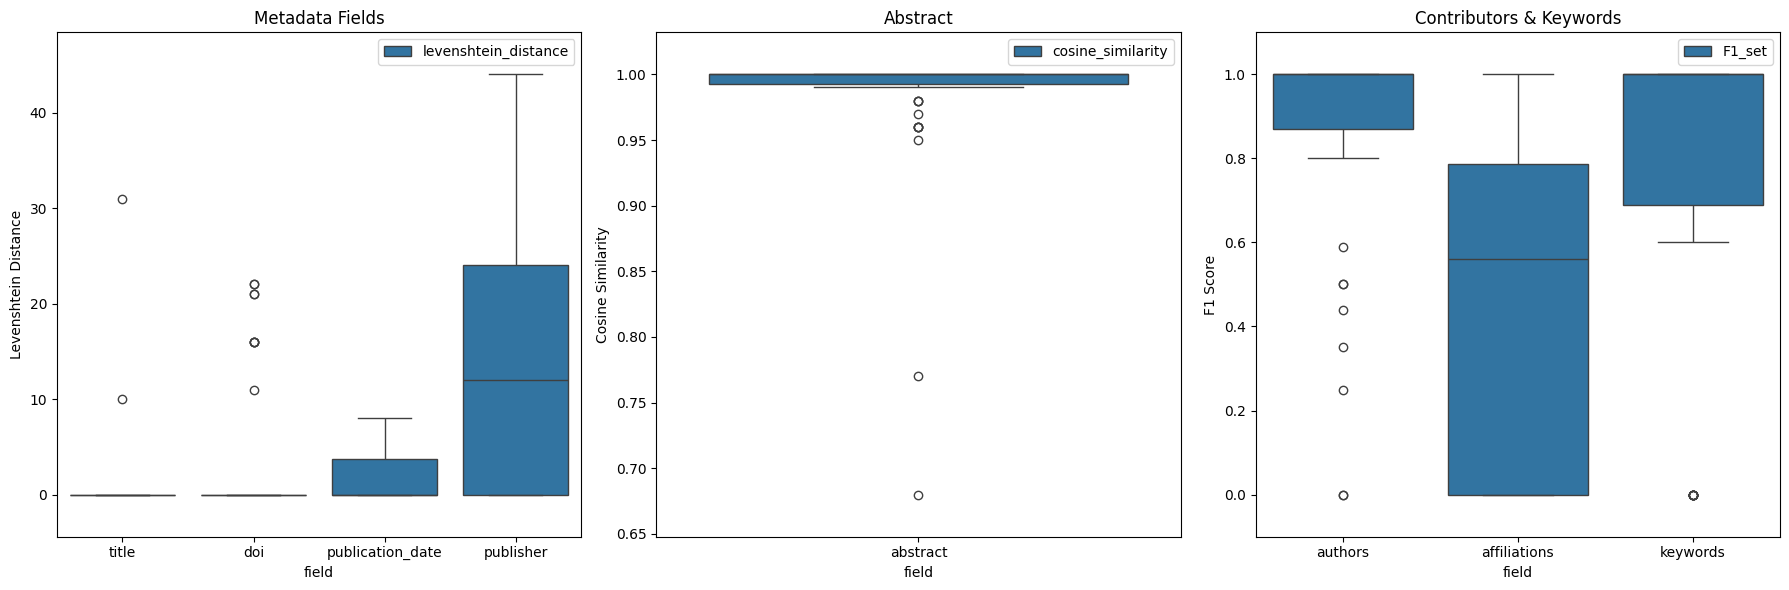

In [ ]:
flat_data = [item for sublist in all_metrics for item in sublist]
df = pd.DataFrame(flat_data)

# Define field groups
group1_fields = ['title', 'doi', 'publication_date', 'publisher']
group2_fields = ['abstract']
group3_fields = ['authors', 'affiliations', 'keywords']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Plot each group with dynamic y-limits
for ax, fields, title, y_field in zip(
    axes,
    [group1_fields, group2_fields, group3_fields],
    ['Metadata Fields', 'Abstract', 'Contributors & Keywords'],
    ["Levenshtein Distance", "Cosine Similarity", "F1 Score"]
):
    subset = df[df['field'].isin(fields)]
    sns.boxplot(data=subset, x='field', y='score', hue='metric', ax=ax)
    ax.set_title(title)
    #ax.set_xlabel('Field')
    ax.set_ylabel(y_field)
    ax.legend(loc=False)

    # Dynamic y-axis limits
    ymin = subset['score'].min()
    ymax = subset['score'].max()
    padding = (ymax - ymin) * 0.1 if ymax != ymin else 0.1
    ax.set_ylim(ymin - padding, ymax + padding)

plt.tight_layout()
plt.show()

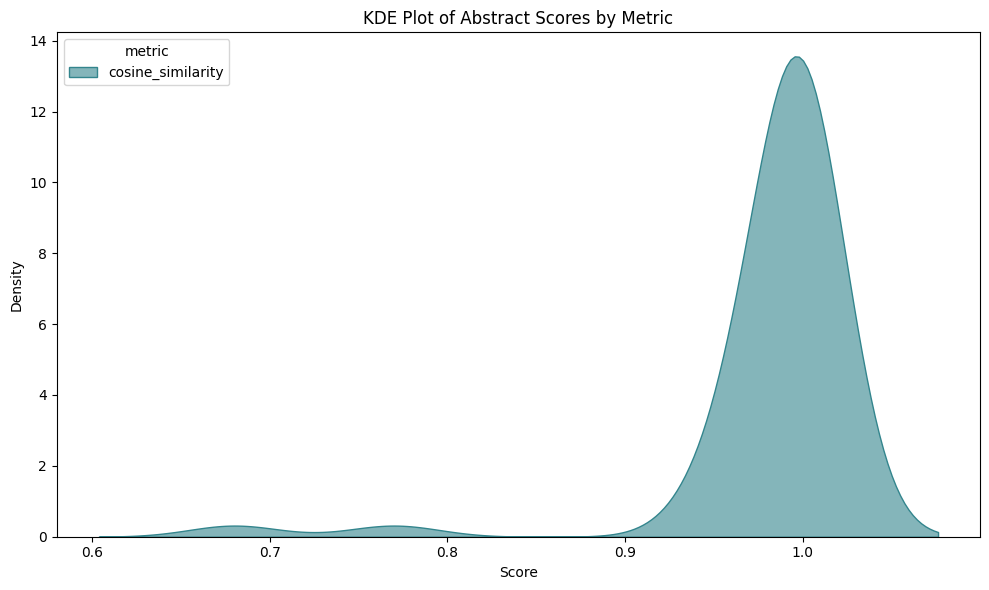

In [ ]:
flat_data = [item for sublist in all_metrics for item in sublist]
df = pd.DataFrame(flat_data)

# Filter for abstract field
abstract_df = df[df['field'] == 'abstract']

# Create KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=abstract_df, x='score', hue='metric', fill=True, common_norm=False, palette='crest', alpha=0.6)
plt.title('KDE Plot of Abstract Scores by Metric')
plt.xlabel('Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()